In [1]:
# Первичная установка кэтбуста
pip install catboost

SyntaxError: invalid syntax (2064492039.py, line 2)

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from catboost import CatBoostRegressor

In [3]:
df = pd.read_excel('C:/Users/Test/Documents/DS/notebooks/udocan/Register_11.03.2023.xlsx')

In [4]:
# Оставляем только закрытые
df = df.query("TQS_Состояние=='Закрыт'")

In [5]:
# Убрал лишние колонки
df = df[['TQS_Инициатор', 'TQS_Организация', 'TQS_Чего касается TQS', 'TQS_РПИ', 'TQS_Проектный офис',  \
    'Длительность отработки запроса']]

In [6]:
# Убрал пропуски
df = df.dropna()

In [7]:
# Разделение на обучение 60%, валидация 20% и тест 20%
train, test = train_test_split(df, train_size = 0.625, random_state = 42)
val, test = train_test_split(test, train_size = 0.5, random_state = 42)

In [8]:
# Проверка длины списков
len(val) / len(train)
#len(test) / len(train)

0.30008266740148803

In [9]:
# Список признаков
X = ['TQS_Инициатор', 'TQS_Организация', 'TQS_Чего касается TQS', 'TQS_РПИ', 'TQS_Проектный офис']
cat_features = ['TQS_Инициатор', 'TQS_Организация', 'TQS_Чего касается TQS', 'TQS_РПИ', 'TQS_Проектный офис']
y = ['Длительность отработки запроса']  # таргет. признак, который мы хотим предсказывать

In [10]:
# Создание параметров дл модели
parameters = {'cat_features' : cat_features,
             'eval_metric' : 'MAPE',
             'verbose' : 100,
             'learning_rate' : 0.035,
             'random_seed' : 42}

# cat_features - список с категорийными колонками
# eval_metric - метрика
# verbose - выводит на печать каждый 100 результат
# random_seed - зафиксили результаты построения модели
# learning_rate - скорость обучения

In [11]:
# Создание модели
model = CatBoostRegressor(**parameters)

In [12]:
# Запуск машинного обучения
model.fit(train[X], train[y], eval_set = (val[X], val[y]))
# bestTest = 1.785939653
# bestIteration = 998

# bestIteration должна быть ближе к концу. Настройки с random_seed

0:	learn: 3.2543130	test: 3.3715582	best: 3.3715582 (0)	total: 199ms	remaining: 3m 18s
100:	learn: 2.8402032	test: 2.9896036	best: 2.9896036 (100)	total: 3.64s	remaining: 32.4s
200:	learn: 2.7500918	test: 2.9465617	best: 2.9465617 (200)	total: 7.61s	remaining: 30.3s
300:	learn: 2.6914452	test: 2.9235236	best: 2.9217095 (276)	total: 11.1s	remaining: 25.8s
400:	learn: 2.6540859	test: 2.9108095	best: 2.9096535 (381)	total: 14.5s	remaining: 21.6s
500:	learn: 2.6051991	test: 2.9042271	best: 2.9002777 (481)	total: 17.8s	remaining: 17.7s
600:	learn: 2.5624431	test: 2.8883310	best: 2.8867616 (592)	total: 21.2s	remaining: 14.1s
700:	learn: 2.5262348	test: 2.8735978	best: 2.8730452 (699)	total: 24.6s	remaining: 10.5s
800:	learn: 2.4885366	test: 2.8720115	best: 2.8720115 (800)	total: 27.7s	remaining: 6.88s
900:	learn: 2.4563578	test: 2.8671557	best: 2.8655714 (894)	total: 30.8s	remaining: 3.38s
999:	learn: 2.4260981	test: 2.8692615	best: 2.8655714 (894)	total: 34s	remaining: 0us

bestTest = 2.865

In [20]:
# Создание массива с предсказанием
model.predict(test[X])

array([ 8.0445815 , 14.9105339 ,  8.85949146, ...,  8.08450543,
        7.22229788,  9.43677248])

In [21]:
# Создание дополнительной колонки с предсказанием в тестовой части
test = test.assign(term_pred = model.predict(test[X]))

In [22]:
# Создание функции для проверки ошибки
def error(y_true, y_pred):
    print('MAE: ', mean_absolute_error(y_true, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_true, y_pred))

In [23]:
# Вывод на печать величины ошибки
error(test['Длительность отработки запроса'], test.term_pred)

MAE:  9.963483195787315
MAPE: 2973350833772313.5


Анализ модели

In [24]:
# Создам копию дф
test_final = test.copy()

In [25]:
# Добавим колонку с ошибками модели
test_final = test_final.assign(model_err = test_final['Длительность отработки запроса'] - test_final.term_pred)

<AxesSubplot:>

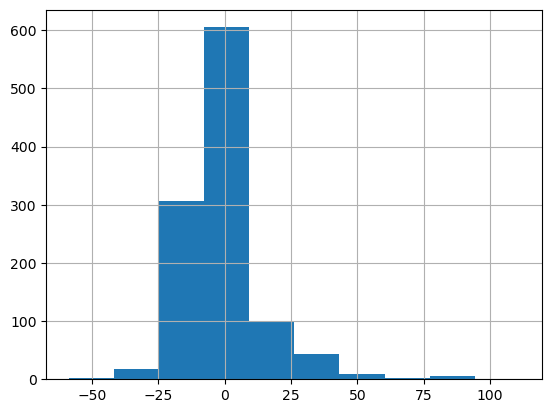

In [26]:
# Посмотрим распределение на графике
test_final.model_err.hist()

In [209]:
# Куда в основном ошибается модель
test_final.model_err.median()
#test.model_err.mean()
#-3.67
# Показывает в среднем на 3,67 дня меньше, чем на самом деле!
# Занижает реальное значение

-3.6755923540813447

In [211]:
# Абсолютная ошибка
test_final = test_final.assign(model_err_abs = abs(test_final.model_err))

<AxesSubplot:>

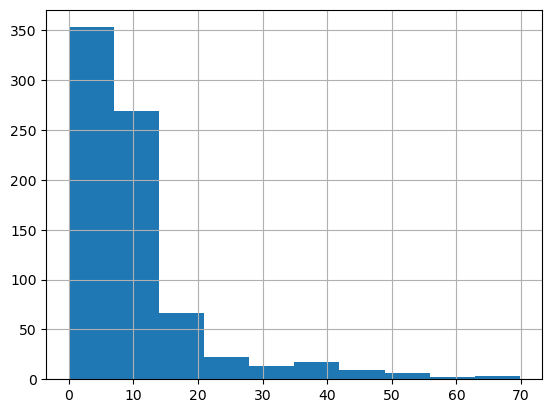

In [216]:
test_final.model_err_abs.hist()

In [215]:
test_final.model_err_abs.describe()

count    760.000000
mean      10.095928
std       10.225273
min        0.016368
25%        3.832041
50%        7.586692
75%       11.950872
max       69.807966
Name: model_err_abs, dtype: float64

In [218]:
# Топ 10 запросов с максимальной ошибкой
test_final.sort_values('model_err_abs', ascending = False).head(10)

,TQS_Инициатор,TQS_Организация,TQS_Чего касается TQS,TQS_РПИ,TQS_Проектный офис,Длительность отработки запроса,term_pred,model_err,model_err_abs
1487,Дирекция по строительству,Дирекция по строительству,Электрика,Механобр инжиниринг,UMCD - ПО-1,86.0,16.192034,69.807966,69.807966
611,Дирекция по строительству,Дирекция по строительству,Электрика,НЭЭПИ,UMCD - ПО-3,83.0,16.967706,66.032294,66.032294
2070,Подрядчик,СтройПроектСервис,Общестрой,ПромГражданПроект,UMCD - ПО-5,72.0,6.530707,65.469293,65.469293
4318,Дирекция по строительству,"Дирекция по строительству - ООО ""Удоканская Медь""",Архитектурные решения,ПЭТ,UMCD - ПО-2,82.0,21.191949,60.808051,60.808051
3858,Подрядчик,Ренейссанс Хэви Индастрис,Электрика,МЕХ,UMCD - ПО-1,79.0,18.305605,60.694395,60.694395
3738,Подрядчик,Ренейссанс Хэви Индастрис,Электрика,МЕХ,UMCD - ПО-1,73.0,18.305605,54.694395,54.694395
645,Дирекция по строительству,Дирекция по строительству,Оборудование,ТОМС Проект,UMCD - ПО-6,77.0,23.785466,53.214534,53.214534
646,Дирекция по строительству,Дирекция по строительству,Электрика,СМАРТ-инжиниринг,UMCD - ПО-6,92.0,39.099585,52.900415,52.900415
1547,Дирекция по строительству,Дирекция по строительству,Электрика,СПб-Гипрошахт,UMCD - ПО-1,71.0,19.813101,51.186899,51.186899
3980,Дирекция по строительству,"Дирекция по строительству - ПО-1 - ООО ""Удокан...",Компоновка / Трубопроводы,МЕХ,UMCD - ПО-1,57.0,7.968110,49.031890,49.031890
